In [1]:
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from mlflow.models.signature import infer_signature

In [2]:
newsgroups = fetch_20newsgroups(subset='all')
data = newsgroups.data
target = newsgroups.target
train_data = fetch_20newsgroups(subset="train", shuffle=True, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset="test", shuffle=True, remove=('headers', 'footers', 'quotes'))

target_names = train_data.target_names
y_train, y_test = train_data.target, test_data.target

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")

X_train = tfidf_vectorizer.fit_transform(train_data.data)
X_test = tfidf_vectorizer.transform(test_data.data)

feature_names = tfidf_vectorizer.get_feature_names_out()


In [3]:
mlflow.set_tracking_uri("http://localhost:5000")

In [4]:
experiment = setup(data=X_train, target=y_train, session_id=25, log_experiment=True, experiment_name='text_classification', html=False)

                    Description                Value
0                    Session id                   25
1                        Target               target
2                   Target type           Multiclass
3           Original data shape       (11314, 17798)
4        Transformed data shape       (11314, 17798)
5   Transformed train set shape        (7919, 17798)
6    Transformed test set shape        (3395, 17798)
7              Numeric features                17797
8                    Preprocess                 True
9               Imputation type               simple
10           Numeric imputation                 mean
11       Categorical imputation                 mode
12               Fold Generator      StratifiedKFold
13                  Fold Number                   10
14                     CPU Jobs                   -1
15                      Use GPU                False
16               Log Experiment         MlflowLogger
17              Experiment Name  text_classifi

In [5]:
best_model = experiment.compare_models(include= ['lr', 'nb', 'ridge', 'svm', 'dt', 'rf'])

2024/10/06 13:04:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/06 13:04:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Ridge Classifier at: http://localhost:5000/#/experiments/255029059618243402/runs/0df3eb58e756439ea6afc6b2667ac83e.
2024/10/06 13:04:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/255029059618243402.
2024/10/06 13:04:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/06 13:04:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM - Linear Kernel at: http://localhost:5000/#/experiments/255029059618243402/runs/3757a93e88ae46169a5d694b05004a3a.
2024/10/06 13:04:42 INFO mlflow.tracking._tracking_service.client: 🧪 View 

                          Model  Accuracy     AUC  Recall   Prec.      F1  \
ridge          Ridge Classifier    0.7479  0.0000  0.7479  0.7556  0.7451   
svm         SVM - Linear Kernel    0.7424  0.0000  0.7424  0.7475  0.7396   
lr          Logistic Regression    0.7305  0.0000  0.7305  0.7426  0.7259   
rf     Random Forest Classifier    0.6493  0.9430  0.6493  0.6559  0.6440   
dt     Decision Tree Classifier    0.4729  0.7349  0.4729  0.4905  0.4759   

        Kappa     MCC  TT (Sec)  
ridge  0.7344  0.7352     7.464  
svm    0.7286  0.7292     8.226  
lr     0.7160  0.7170    10.136  
rf     0.6304  0.6314    12.246  
dt     0.4447  0.4458    10.923  


In [6]:
experiment.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

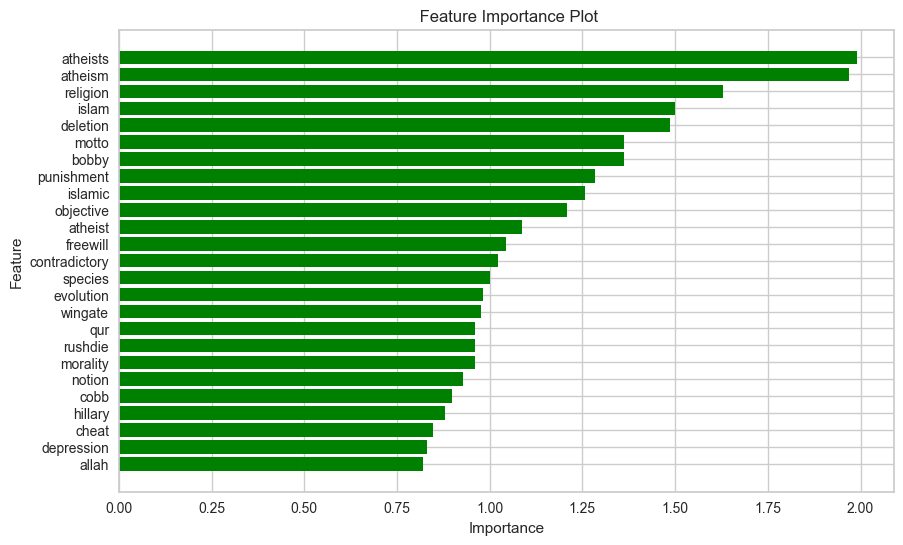

In [16]:
feature_importance = np.abs(best_model.coef_[0])

top_n = 25
indices = feature_importance.argsort()[-top_n:][::-1]  
top_features = [feature_names[i] for i in indices]
top_importance = feature_importance[indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color="green")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(' Feature Importance Plot')
plt.gca().invert_yaxis() 

feature_importance_path = "feature_importance.png"
plt.savefig(feature_importance_path)
mlflow.log_artifact(feature_importance_path)


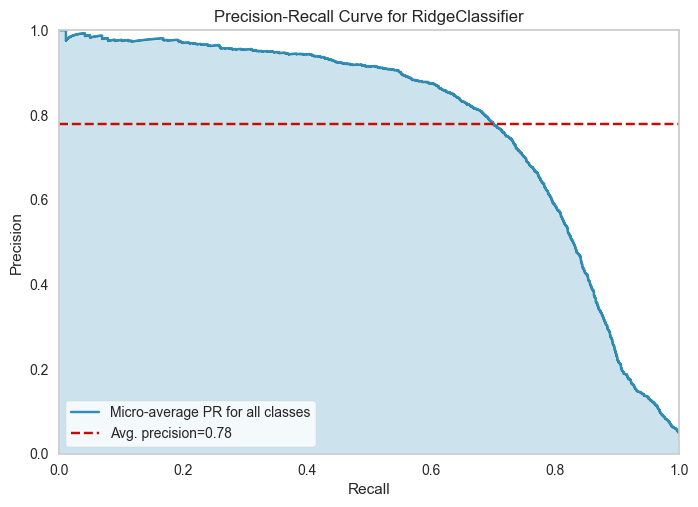

In [8]:
plot_model(best_model, plot = 'pr')

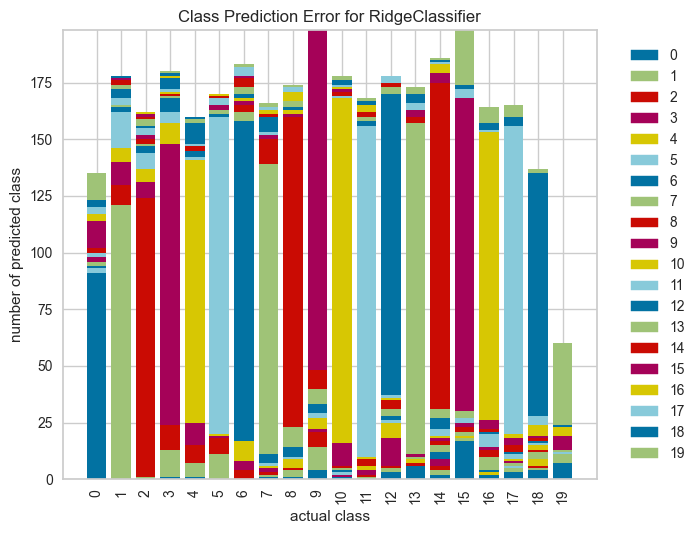

In [9]:
plot_model(best_model, plot = 'error')

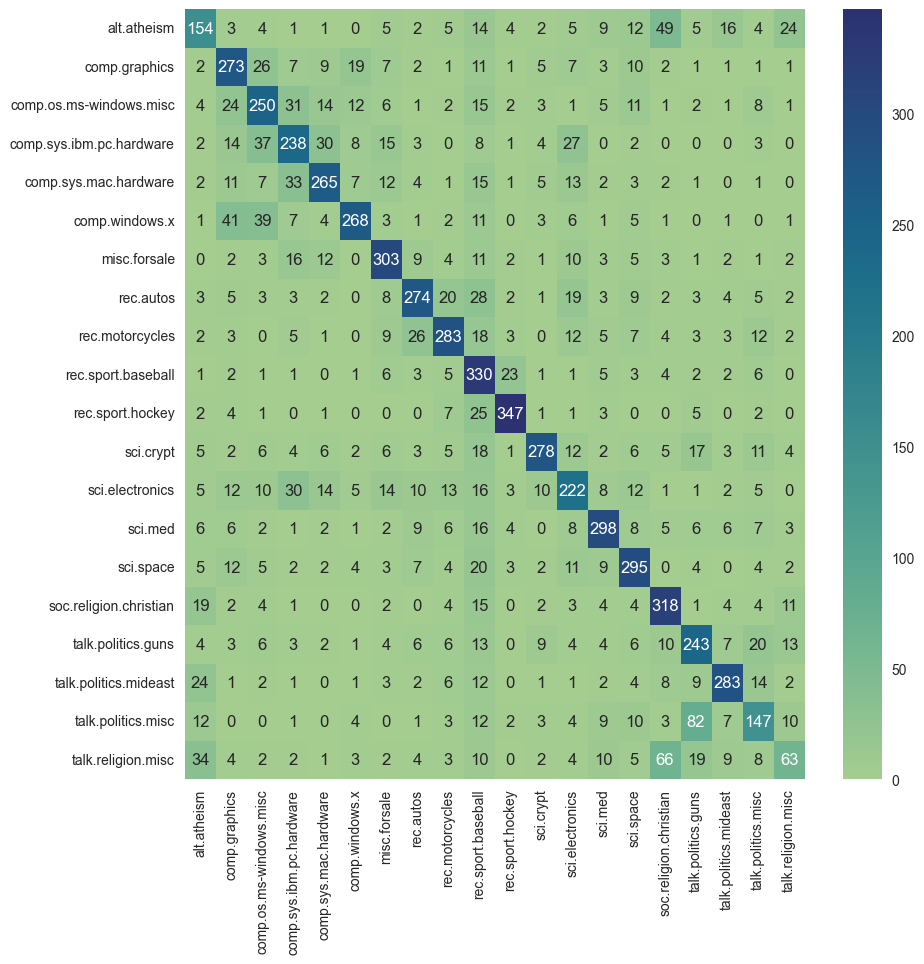

In [18]:
y_predicted = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predicted)

plt.figure(figsize = (10,10))
svm = sns.heatmap(conf_matrix, annot = True, cmap='crest', xticklabels = target_names, yticklabels = class_names, fmt='g')

cm_path = "confusion_matrix.png"
plt.savefig(cm_path)
mlflow.log_artifact(cm_path)

In [11]:
report = classification_report(y_test, y_predicted, output_dict=True)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.54      0.48      0.51       319
           1       0.64      0.70      0.67       389
           2       0.61      0.63      0.62       394
           3       0.61      0.61      0.61       392
           4       0.72      0.69      0.71       385
           5       0.80      0.68      0.73       395
           6       0.74      0.78      0.76       390
           7       0.75      0.69      0.72       396
           8       0.74      0.71      0.73       398
           9       0.53      0.83      0.65       397
          10       0.87      0.87      0.87       399
          11       0.83      0.70      0.76       396
          12       0.60      0.56      0.58       393
          13       0.77      0.75      0.76       396
          14       0.71      0.75      0.73       394
          15       0.66      0.80      0.72       398
          16       0.60      0.67      0.63       364
          17       0.81    

In [12]:
metrics_mlflow_dict = {}
for metric in ['weighted avg', 'macro avg']:
    for mm, v in report[metric].items():
        metrics_mlflow_dict[f"{metric.replace(' ', '_')}_{mm}"] = v

mlflow.log_metrics(metrics_mlflow_dict)
mlflow.log_metric('accuracy', report['accuracy'])

In [13]:
plot_path = plot_model(best_model, plot='pr', save=True)
mlflow.log_artifact(plot_path)

error_path = plot_model(best_model, plot='error', save=True)
mlflow.log_artifact(error_path)